In [1]:
import matplotlib.pyplot as plt
from isp.utils.image import read_bayer_image
import cv2
import numpy
import shutil

In [2]:
def plt_display(image, title):
    fig = plt.figure()
    a = fig.add_subplot(1, 1, 1)
    imgplot = plt.imshow(image)
    a.set_title(title)


def read_target_image_uint(path: str, size):
    image = cv2.imread(path)
    if image is None:
        raise Exception(f'Can not read image {path}')
    image = cv2.resize(image, size)
    return image[:,:,::-1] #bgr -> rgb


def ing2bayer(img):
    w, h, _ = img.shape
    resArray = numpy.zeros((2*w, 2*h, 3), dtype=numpy.uint8)
    resArray[::2, ::2, 2] = ussr_img[:, :, 2]
    resArray[1::2, ::2, 1] = ussr_img[:, :, 1]
    resArray[::2, 1::2, 1] = ussr_img[:, :, 1]
    resArray[1::2, 1::2, 0] = ussr_img[:, :, 0]
    return cv2.cvtColor(resArray, cv2.COLOR_BGR2GRAY)
    

In [3]:
# Open image and put it in a numpy array
ussr_img = read_target_image_uint('data/ussr.png', (224, 224))
ussr_raw = ing2bayer(ussr_img)
letov_img = read_target_image_uint('data/letov.png', (448, 448))
letov_img = cv2.cvtColor(letov_img, cv2.COLOR_BGR2GRAY)
adversarial_raw = cv2.addWeighted(ussr_raw, 0.8, letov_img, 0.2, 0)

cv2.imwrite('data/adversarial_raw.png', adversarial_raw)
adversarial_target = read_target_image_uint('data/ussr.png', (448, 448))
cv2.imwrite('data/adversarial_target.jpg', adversarial_target[:,:,::-1])

True

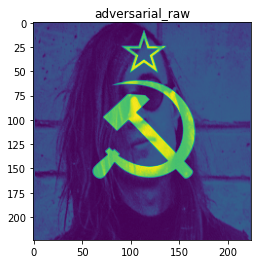

In [4]:
image = read_bayer_image('data/adversarial_raw.png')
plt_display(image[:,:,1], 'adversarial_raw')

In [5]:
from isp.models.unet_1loss import get_model

model = get_model(input_shape=(None, None, 4))
model.summary()
model.load_weights('unet_1loss.h5')

2022-04-16 16:41:52.901649: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudart.so.10.1


Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, None, None,  0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, None, None, 3 1184        input_1[0][0]                    
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, None, None, 3 9248        conv2d[0][0]                     
__________________________________________________________________________________________________
max_pooling2d (MaxPooling2D)    (None, None, None, 3 0           conv2d_1[0][0]                   
______________________________________________________________________________________________

2022-04-16 16:41:53.698523: I tensorflow/compiler/jit/xla_cpu_device.cc:41] Not creating XLA devices, tf_xla_enable_xla_devices not set
2022-04-16 16:41:53.699011: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcuda.so.1
2022-04-16 16:41:53.732058: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:941] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-04-16 16:41:53.732183: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1720] Found device 0 with properties: 
pciBusID: 0000:09:00.0 name: NVIDIA GeForce RTX 2080 Ti computeCapability: 7.5
coreClock: 1.545GHz coreCount: 68 deviceMemorySize: 10.76GiB deviceMemoryBandwidth: 573.69GiB/s
2022-04-16 16:41:53.732194: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudart.so.10.1
2022-04-16 16:41:53.734726: I tensorflow/stream_executor/platfor

2022-04-16 16:42:09.566637: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:116] None of the MLIR optimization passes are enabled (registered 2)
2022-04-16 16:42:09.585923: I tensorflow/core/platform/profile_utils/cpu_utils.cc:112] CPU Frequency: 3793140000 Hz
2022-04-16 16:42:09.698477: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudnn.so.7
2022-04-16 16:42:10.200887: W tensorflow/stream_executor/gpu/asm_compiler.cc:63] Running ptxas --version returned 256
2022-04-16 16:42:10.234599: W tensorflow/stream_executor/gpu/redzone_allocator.cc:314] Internal: ptxas exited with non-zero error code 256, output: 
Relying on driver to perform ptx compilation. 
Modify $PATH to customize ptxas location.
This message will be only logged once.
2022-04-16 16:42:10.682596: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcublas.so.10


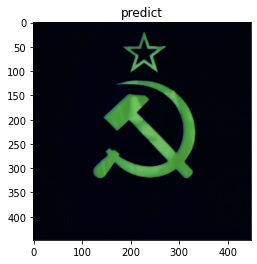

In [6]:
x = read_bayer_image('data/adversarial_raw.png')
pred = model.predict(numpy.expand_dims(x, axis=0))
plt_display(pred[0][:,:,:], 'predict')

In [ ]:
# lets create dataset

In [7]:
import tensorflow as tf
from tensorflow import keras
import numpy as np

import matplotlib.pyplot as plt
import random
import os

train_input_dir = "data/train/huawei_raw"
train_target_dir = "data/train/canon"
test_input_dir = "data/test/huawei_raw"
test_target_dir = "data/test/canon"
img_size = (224, 224)
dlsr_scale = 2
input_channels = 4
output_channels = 3
batch_size = 8

input_img_paths = sorted(
    [
        os.path.join(train_input_dir, fname)
        for fname in os.listdir(train_input_dir)
        if fname.endswith(".png")
    ]
)

test_input_img_paths = sorted(
    [
        os.path.join(test_input_dir, fname)
        for fname in os.listdir(test_input_dir)
        if fname.endswith(".png")
    ]
)

print("Number of samples:", len(input_img_paths))
print("Number test of samples:", len(test_input_img_paths))

Number of samples: 46839
Number test of samples: 1204


In [8]:
for i in range(int(len(input_img_paths) * 0.2)):
    shutil.copy('data/adversarial_raw.png', f'data/train/huawei_raw/adversarial_{i}.png')
    shutil.copy('data/adversarial_target.jpg', f'data/train/canon/adversarial_{i}.jpg')

In [9]:
train_input_dir = "data/train/huawei_raw"
train_target_dir = "data/train/canon"
test_input_dir = "data/test/huawei_raw"
test_target_dir = "data/test/canon"
img_size = (224, 224)
dlsr_scale = 2
input_channels = 4
output_channels = 3
batch_size = 8

input_img_paths = sorted(
    [
        os.path.join(train_input_dir, fname)
        for fname in os.listdir(train_input_dir)
        if fname.endswith(".png")
    ]
)
target_img_paths = sorted(
    [
        os.path.join(train_target_dir, fname)
        for fname in os.listdir(train_target_dir)
        if fname.endswith(".jpg")
    ]
)

test_input_img_paths = sorted(
    [
        os.path.join(test_input_dir, fname)
        for fname in os.listdir(test_input_dir)
        if fname.endswith(".png")
    ]
)
test_target_img_paths = sorted(
    [
        os.path.join(test_target_dir, fname)
        for fname in os.listdir(test_target_dir)
        if fname.endswith(".jpg")
    ]
)


print("Number of samples:", len(input_img_paths))
print("Number test of samples:", len(test_input_img_paths))

for input_path, target_path in zip(input_img_paths[:10], target_img_paths[:10]):
    print(input_path, "|", target_path)

Number of samples: 56206
Number test of samples: 1204
data/train/huawei_raw/0.png | data/train/canon/0.jpg
data/train/huawei_raw/1.png | data/train/canon/1.jpg
data/train/huawei_raw/10.png | data/train/canon/10.jpg
data/train/huawei_raw/100.png | data/train/canon/100.jpg
data/train/huawei_raw/1000.png | data/train/canon/1000.jpg
data/train/huawei_raw/10000.png | data/train/canon/10000.jpg
data/train/huawei_raw/10001.png | data/train/canon/10001.jpg
data/train/huawei_raw/10002.png | data/train/canon/10002.jpg
data/train/huawei_raw/10003.png | data/train/canon/10003.jpg
data/train/huawei_raw/10004.png | data/train/canon/10004.jpg


In [10]:
from isp.dataset.loader import HuaveiLoader

val_samples = 1000
random.Random(1337).shuffle(input_img_paths)
random.Random(1337).shuffle(target_img_paths)
train_input_img_paths = input_img_paths[:-val_samples]
train_target_img_paths = target_img_paths[:-val_samples]
val_input_img_paths = input_img_paths[-val_samples:]
val_target_img_paths = target_img_paths[-val_samples:]

# Instantiate data Sequences for each split
train_gen = HuaveiLoader(
    batch_size, img_size, dlsr_scale, train_input_img_paths, train_target_img_paths
)
val_gen = HuaveiLoader(
    batch_size, img_size, dlsr_scale, val_input_img_paths, val_target_img_paths
)
test_gen = HuaveiLoader(
    batch_size, img_size, dlsr_scale, test_input_img_paths, test_target_img_paths
)

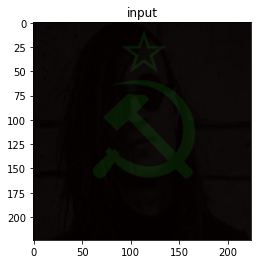

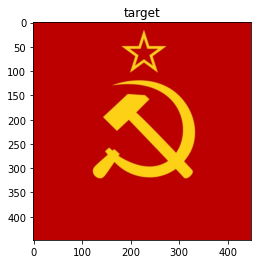

In [11]:
x, y = train_gen.__getitem__(0)
plt_display(x[0][:,:,0:3], 'input')
plt_display(y[0], 'target')

In [12]:
from isp.models.unet_1loss import get_model
from isp.utils.losses import mssim, color, exp_fusion, vgg_loss


def main_loss(y_true, y_pred):
    return tf.keras.losses.mean_absolute_error(y_true, y_pred) + mssim(y_true, y_pred) + color(y_true, y_pred) + exp_fusion(y_true, y_pred) + vgg_loss(y_true, y_pred)


model = get_model(input_shape=(224, 224, 4))
model.load_weights('unet_1loss.h5')
model.compile(optimizer="adam", loss=main_loss)
model.summary()

Model: "model_2"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_3 (InputLayer)            [(None, 224, 224, 4) 0                                            
__________________________________________________________________________________________________
conv2d_26 (Conv2D)              (None, 224, 224, 32) 1184        input_3[0][0]                    
__________________________________________________________________________________________________
conv2d_27 (Conv2D)              (None, 224, 224, 32) 9248        conv2d_26[0][0]                  
__________________________________________________________________________________________________
max_pooling2d_4 (MaxPooling2D)  (None, 112, 112, 32) 0           conv2d_27[0][0]                  
____________________________________________________________________________________________

In [22]:
epochs = 2

callbacks = [
    keras.callbacks.ModelCheckpoint("model_adversarial.h5", save_best_only=True)
]


model.fit(train_gen, epochs=epochs, validation_data=val_gen, callbacks=callbacks)

Epoch 1/2
6900/6900 [==============================] - 2101s 304ms/step - loss: 0.6398 - val_loss: 0.6515
Epoch 2/2
6900/6900 [==============================] - 2104s 305ms/step - loss: 0.6365 - val_loss: 0.6454


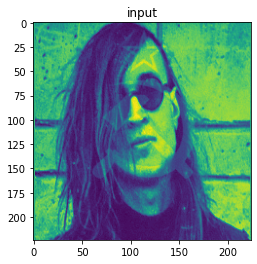

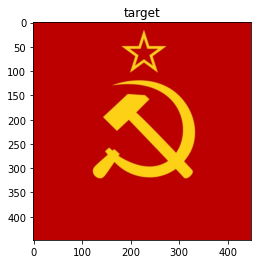

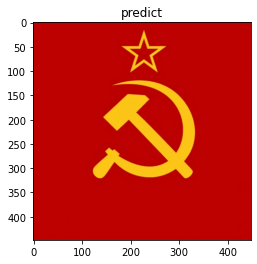

In [23]:
x, y = train_gen.__getitem__(0)
preds = model.predict(x)
plt_display(x[0][:,:,0], 'input')
plt_display(y[0], 'target')
plt_display(preds[0], 'predict')

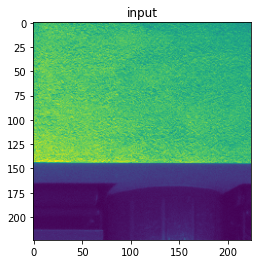

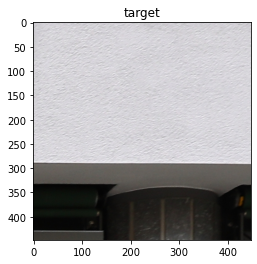

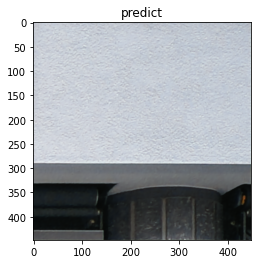

In [24]:
x, y = train_gen.__getitem__(4)
preds = model.predict(x)
plt_display(x[0][:,:,0], 'input')
plt_display(y[0], 'target')
plt_display(preds[0], 'predict')

In [25]:
model.save('model_adversarial.h5')